In [1]:
%matplotlib inline
import keras
from keras import backend as K
import scipy
import skimage
import skimage.transform
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import imageio
import tqdm
import tensorflow as tf

/home/crosarko/anaconda3/envs/AI/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
shape = (400,400,3)
content_filename = "images/me.jpg"
starry_filename = "images/VanGogh.jpg"
retro_filename = "images/pixelart.jpeg"

In [3]:
network_class = keras.applications.inception_resnet_v2
model = network_class.InceptionResNetV2(include_top=False,input_shape=shape)

print("Model layers:")
for a in model.layers:
    print(a.name)

Model layers:
input_1
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
conv2d_3
batch_normalization_3
activation_3
max_pooling2d_1
conv2d_4
batch_normalization_4
activation_4
conv2d_5
batch_normalization_5
activation_5
max_pooling2d_2
conv2d_9
batch_normalization_9
activation_9
conv2d_7
conv2d_10
batch_normalization_7
batch_normalization_10
activation_7
activation_10
average_pooling2d_1
conv2d_6
conv2d_8
conv2d_11
conv2d_12
batch_normalization_6
batch_normalization_8
batch_normalization_11
batch_normalization_12
activation_6
activation_8
activation_11
activation_12
mixed_5b
conv2d_16
batch_normalization_16
activation_16
conv2d_14
conv2d_17
batch_normalization_14
batch_normalization_17
activation_14
activation_17
conv2d_13
conv2d_15
conv2d_18
batch_normalization_13
batch_normalization_15
batch_normalization_18
activation_13
activation_15
activation_18
block35_1_mixed
block35_1_conv
block35_1
block35_1_ac
conv2d_22
batch_normalization_22
activation_

In [30]:
style_layers = [model.get_layer('activation_{}'.format(o)).output for o in range(10,20)]
content_layers = [model.get_layer('activation_{}'.format(o)).output for o in range(190,200)]


In [31]:
preprocess = network_class.preprocess_input

mean = np.array([123.68, 116.779, 103.939], dtype=np.float32) #Extracted from keras.applications.imagenet_utils

#def deprocess(processed_image):
#    return np.clip(processed_image[:, :, ::-1] + mean, 0, 255)/255

def deprocess(processed_image):
    return np.clip((processed_image + 1)/2,0,1)

def load_image(filename,shape):
    image = plt.imread(filename) 
    if image.shape[2] == 4:
        image = image[:,:,:3]
    resized = skimage.transform.resize(image,shape,mode="constant").astype(np.float32) * 255 
    return resized,preprocess(resized.copy())


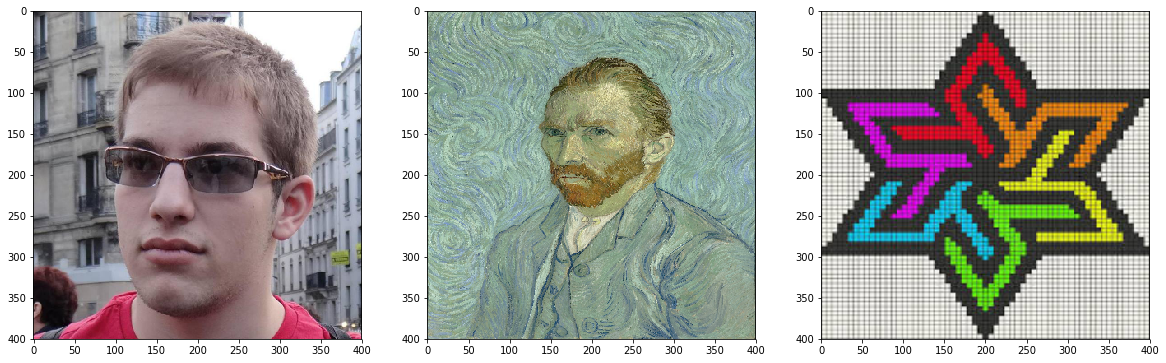

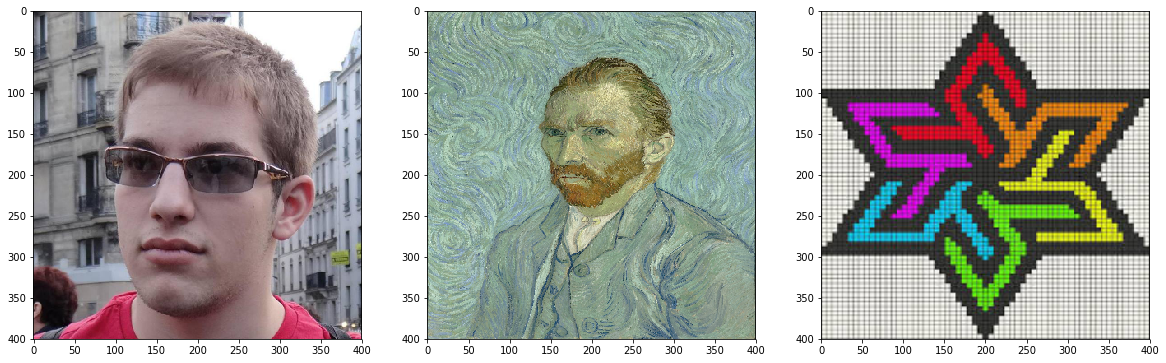

In [32]:
content,content_preprocessed = load_image(content_filename,shape)
starry_night,starry_night_preprocessed = load_image(starry_filename,shape)
retro,retro_preprocessed = load_image(retro_filename,shape)

fig,ax = plt.subplots(1,3,figsize=(20,10))
ax[0].imshow(content/255)
ax[1].imshow(starry_night/255)                      
ax[2].imshow(retro/255)                      

fig,ax = plt.subplots(1,3,figsize=(20,10))
ax[0].imshow(deprocess(content_preprocessed))
ax[1].imshow(deprocess(starry_night_preprocessed))                      
ax[2].imshow(deprocess(retro_preprocessed))                      


In [33]:
class Evaluator(object):
    def __init__(self, f, shp): self.f, self.shp = f, shp
        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)

    def grads(self, x): return self.grad_values.flatten().astype(np.float64)
    
def mse(layer,target):
    return K.mean((layer-target)**2)

def solve_image(eval_obj, niter, x,name,iq):
    for i in tqdm.tqdm(list(range(niter))):
        x, min_val, info = scipy.optimize.fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        imageio.imwrite("results/{}_at_iteration_{}.png".format(name,i), 
                        (deprocess(join_yiq_to_bgr(x.reshape(shape),iq))*255).astype(np.uint8))
    return x

def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    the_dot = K.dot(features, K.transpose(features))
    tensor = tf.cast(K.prod(x.get_shape()[1:3]),tf.float32)
    num_elems = tensor
    return the_dot / num_elems

def style_loss(x, targ): 
    return mse(gram_matrix(x), gram_matrix(targ))

def style_transfer(input_content,input_style,content_multiplier,style_multiplier,name,iq): 
    input_content = np.expand_dims(input_content,0)
    input_style = np.expand_dims(input_style,0)
    
    content_model = keras.Model(model.input, content_layers)
    style_model = keras.Model(model.input, style_layers)

    content_targets = [K.variable(output) for output in content_model.predict(input_content)]
    style_targets = [K.variable(output) for output in style_model.predict(input_style)]    
    
    style_losses = [style_loss(layer[0], target[0]) for layer,target in zip(style_layers, style_targets)]
    content_losses = [mse(layer, target) for layer,target in zip(content_layers, content_targets)]

    _style_loss = K.mean(K.stack(style_losses))
    content_loss = K.mean(K.stack(content_losses))
    
    loss = content_multiplier*content_loss + style_multiplier*_style_loss
    
    grads = K.gradients(loss, model.input)
    fn = K.function([model.input], [loss]+grads)
    evaluator = Evaluator(fn, input_content.shape)
    
    x = input_content.copy()#np.random.uniform(-2.5, 2.5, [1]+list(shape))/100
    x = solve_image(evaluator, 5, x,name,iq)
    x = x.reshape(shape)

    fig,ax = plt.subplots(1,3,figsize=(20,10))
    ax[0].imshow(deprocess(join_yiq_to_bgr(input_content[0],iq)))
    ax[1].imshow(deprocess(join_yiq_to_bgr(input_style[0],iq)))                      
    ax[2].imshow(deprocess(join_yiq_to_bgr(x,iq)))       
    
    del evaluator, fn, grads, loss, content_targets,style_targets,content_model,style_model
    return x

In [34]:
def bgr_to_yiq(x):
    transform = np.asarray([[0.114, 0.587, 0.299], [-0.322, -0.274, 0.596], [0.312, -0.523, 0.211]], dtype=np.float32)
    h, w, c = x.shape
    x = x.transpose((2, 0, 1)).reshape((c, -1))
    x = transform.dot(x)
    return x.reshape((c, h, w)).transpose((1, 2, 0))

def yiq_to_bgr(x):
    transform = np.asarray([[1, -1.106, 1.703], [1, -0.272, -0.647], [1, 0.956, 0.621]], dtype=np.float32)
    h, w, c = x.shape
    x = x.transpose((2, 0, 1)).reshape((c, -1))
    x = transform.dot(x)
    return x.reshape((c, h, w)).transpose((1, 2, 0))

def split_bgr_to_yiq(x):
    x = bgr_to_yiq(x)
    y = x[:,:,0:1]
    iq = x[:,:,1:]
    return np.repeat(y, 3, axis=2), iq

def join_yiq_to_bgr(y, iq):
    y = bgr_to_yiq(y)[:,:,0:1]
    return yiq_to_bgr(np.concatenate((y, iq), axis=2))

def luminance_transfer(x,y):
    # x: style, y:content
    x_l, x_iq = split_bgr_to_yiq(x) # 1x3x512x512
    y_l, y_iq = split_bgr_to_yiq(y)

    x_l_mean = np.mean(x_l)
    y_l_mean = np.mean(y_l)
    x_l_std = np.std(x_l)
    y_l_std = np.std(y_l)

    x_l = (y_l_std/x_l_std)*(x_l - x_l_mean) + y_l_mean
    return x_l, y_l, y_iq


 20%|██        | 1/5 [00:13<00:55, 13.98s/it]

Current loss value: 0.003299302887171507


 40%|████      | 2/5 [00:14<00:21,  7.26s/it]

Current loss value: 0.003299302887171507


 60%|██████    | 3/5 [00:15<00:10,  5.01s/it]

Current loss value: 0.003299302887171507


 80%|████████  | 4/5 [00:15<00:03,  3.90s/it]

Current loss value: 0.003299302887171507


100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

Current loss value: 0.003299302887171507


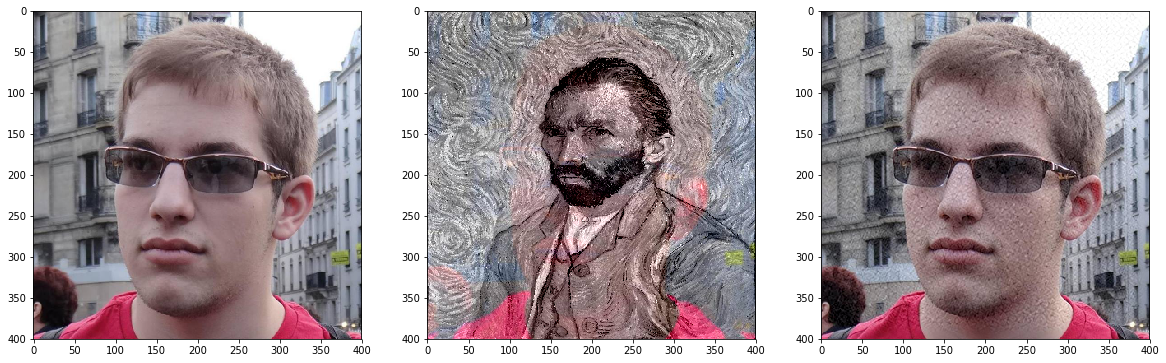

In [35]:
starry_luminance, content_luminance_starry, starry_iq = luminance_transfer(starry_night_preprocessed,content_preprocessed)


me_starry_night = style_transfer(content_luminance_starry,starry_luminance,0.001,"van_gogh",starry_iq)

 20%|██        | 1/5 [00:17<01:09, 17.27s/it]

Current loss value: 0.0069816745817661285


 40%|████      | 2/5 [00:21<00:31, 10.66s/it]

Current loss value: 0.0033962149173021317


 60%|██████    | 3/5 [00:21<00:14,  7.29s/it]

Current loss value: 0.0033962149173021317


 80%|████████  | 4/5 [00:22<00:05,  5.61s/it]

Current loss value: 0.0033962149173021317


100%|██████████| 5/5 [00:22<00:00,  4.60s/it]

Current loss value: 0.0033962149173021317


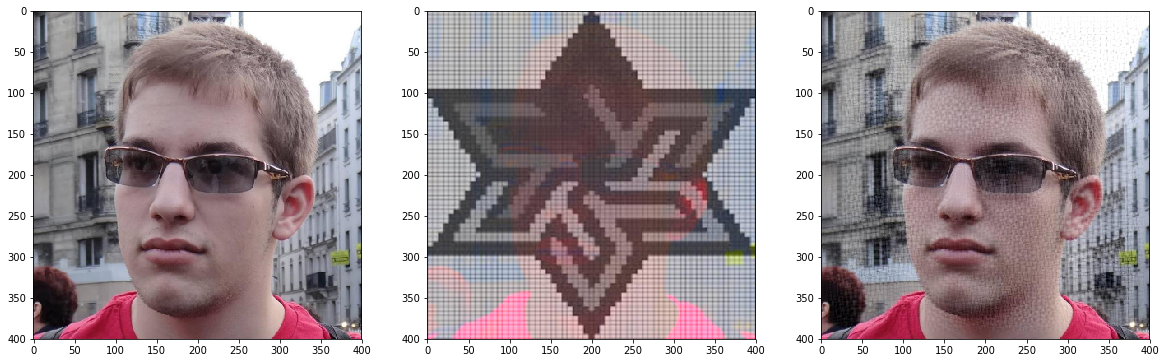

In [36]:
retro_luminance, content_luminance_retro, retro_iq = luminance_transfer(retro_preprocessed,content_preprocessed)


me_retro = style_transfer(content_luminance_retro,retro_luminance,1,"retro",retro_iq)

(0.0, 1.0)

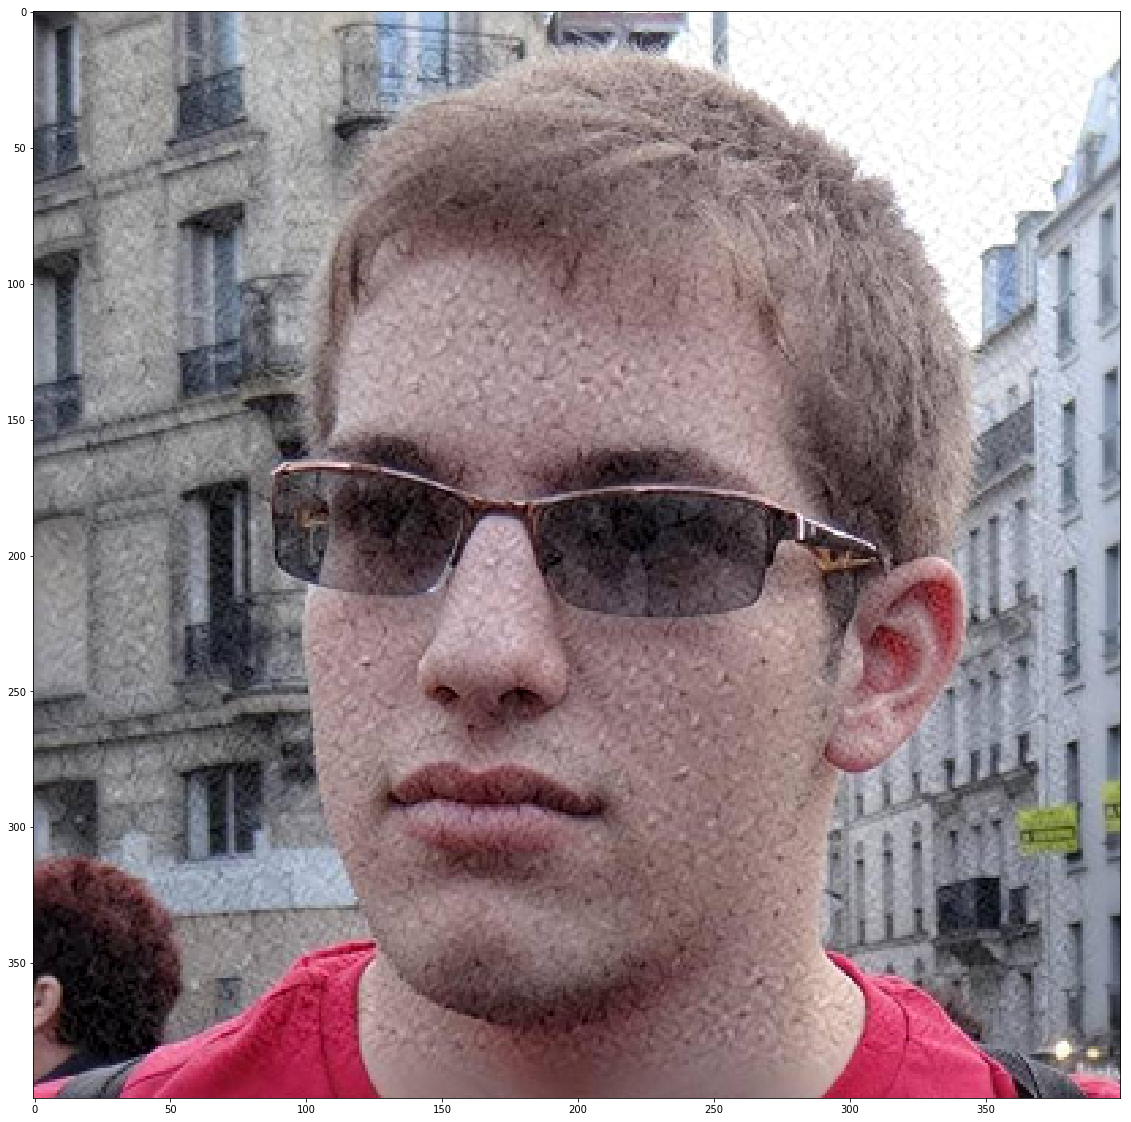

In [37]:
outImg = join_yiq_to_bgr(me_starry_night,starry_iq)
deprocessed = deprocess(outImg)
plt.figure(figsize=(20,20))
plt.imshow(deprocessed)
deprocessed.min(),deprocessed.max()

In [ ]:
imageio.imwrite("results/me_gogh.png",(deprocessed*255).astype(np.uint8))

In [13]:
preprocess??